## 📦 Step 1: Importar Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import random
from tqdm import tqdm

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas correctamente")
print(f"PyTorch versión: {torch.__version__}")

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 GPU NVIDIA detectada (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 GPU Apple Silicon detectada (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Usando CPU")

print(f"🖥️  Dispositivo de cómputo: {device}")

✅ Librerías importadas correctamente
PyTorch versión: 2.9.1
🍎 GPU Apple Silicon detectada (MPS)
🖥️  Dispositivo de cómputo: mps


## ⚙️ Step 2: Configuración

In [2]:
# ============================================
# CONFIGURACIÓN
# ============================================

# Rutas
DATA_DIR = Path("../data")
MODELS_DIR = Path("../models")
SYNTH_DIR = Path("../../SignalBuilderC/data")  # Datos sintéticos CoSiBD
MODELS_DIR.mkdir(exist_ok=True)

# Parámetros del modelo
INPUT_SIZE = 1000
OUTPUT_SIZE = 5000
UPSAMPLE_FACTOR = OUTPUT_SIZE // INPUT_SIZE  # 5x

# Parámetros de entrenamiento
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

# Semilla para reproducibilidad
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*60)
print("CONFIGURACIÓN - MODELO MIXED-AUDIO")
print("="*60)
print(f"📂 Datos audio: {DATA_DIR}")
print(f"📂 Datos sintéticos: {SYNTH_DIR}")
print(f"💾 Modelos: {MODELS_DIR}")
print(f"\n--- Arquitectura ---")
print(f"📊 Input size: {INPUT_SIZE}")
print(f"📊 Output size: {OUTPUT_SIZE}")
print(f"⬆️  Upsample factor: {UPSAMPLE_FACTOR}x")
print(f"\n--- Entrenamiento ---")
print(f"🔄 Epochs: {EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate: {LEARNING_RATE}")
print("="*60)

CONFIGURACIÓN - MODELO MIXED-AUDIO
📂 Datos audio: ../data
📂 Datos sintéticos: ../../SignalBuilderC/data
💾 Modelos: ../models

--- Arquitectura ---
📊 Input size: 1000
📊 Output size: 5000
⬆️  Upsample factor: 5x

--- Entrenamiento ---
🔄 Epochs: 100
📦 Batch size: 32
📈 Learning rate: 0.001


## 📥 Step 3: Cargar Datos de Audio

In [7]:
# Cargar datos de audio
training_dir = DATA_DIR / "training"

x_audio_train = np.loadtxt(training_dir / "x_audio_train.txt")
y_audio_train = np.loadtxt(training_dir / "y_audio_train.txt")

print("="*60)
print("DATOS DE AUDIO CARGADOS")
print("="*60)
print(f"📊 Audio:")
print(f"   x_audio_train: {x_audio_train.shape}")
print(f"   y_audio_train: {y_audio_train.shape}")
print("="*60)

DATOS DE AUDIO CARGADOS
📊 Audio:
   x_audio_train: (500, 1000)
   y_audio_train: (500, 5000)


## 📥 Step 4: Cargar Datos Sintéticos (CoSiBD)

In [8]:
# Cargar datos sintéticos consolidados
# Los datos CoSiBD están en archivos consolidados, no individuales

synth_high_file = SYNTH_DIR / "signals_high_resolution_5000.npz"
synth_low_file = SYNTH_DIR / "signals_subsampled_simple_1000.npz"

print(f"📁 Buscando datos sintéticos:")
print(f"   High-res: {synth_high_file.exists()}")
print(f"   Low-res: {synth_low_file.exists()}")

# Cargar señales sintéticas
data_high = np.load(synth_high_file)
data_low = np.load(synth_low_file)

print(f"\n📦 Contenido de los archivos:")
print(f"   High-res keys: {list(data_high.keys())}")
print(f"   Low-res keys: {list(data_low.keys())}")

# Extraer arrays
y_synth_full = data_high['signals']  # (N, 5000)
x_synth_full = data_low['signals']   # (N, 1000)

print(f"\n📊 Señales sintéticas disponibles:")
print(f"   y_synth_full (5000 pts): {y_synth_full.shape}")
print(f"   x_synth_full (1000 pts): {x_synth_full.shape}")

# Usar 500 señales para igualar cantidad de audio
N_SYNTH = 500
x_synth = x_synth_full[:N_SYNTH]
y_synth = y_synth_full[:N_SYNTH]

print(f"\n📊 Usando {N_SYNTH} señales sintéticas:")
print(f"   x_synth: {x_synth.shape}")
print(f"   y_synth: {y_synth.shape}")

# Verificar compatibilidad con audio
print(f"\n🔍 Verificación de compatibilidad:")
print(f"   Audio x_train: {x_audio_train.shape}")
print(f"   Synth x_synth: {x_synth.shape}")
print(f"   ¿Compatible? {x_audio_train.shape[1] == x_synth.shape[1] and y_audio_train.shape[1] == y_synth.shape[1]}")

📁 Buscando datos sintéticos:
   High-res: True
   Low-res: True

📦 Contenido de los archivos:
   High-res keys: ['signals', 't', 'clean_signals']
   Low-res keys: ['signals', 't']

📊 Señales sintéticas disponibles:
   y_synth_full (5000 pts): (2500, 5000)
   x_synth_full (1000 pts): (2500, 1000)

📊 Usando 500 señales sintéticas:
   x_synth: (500, 1000)
   y_synth: (500, 5000)

🔍 Verificación de compatibilidad:
   Audio x_train: (500, 1000)
   Synth x_synth: (500, 1000)
   ¿Compatible? True


## 🔀 Step 5: Mezclar Datos

In [9]:
# Combinar datos de audio y sintéticos
x_mixed = np.concatenate([x_audio_train, x_synth], axis=0)
y_mixed = np.concatenate([y_audio_train, y_synth], axis=0)

# Mezclar aleatoriamente
shuffle_indices = np.random.permutation(len(x_mixed))
x_mixed = x_mixed[shuffle_indices]
y_mixed = y_mixed[shuffle_indices]

print("="*60)
print("DATOS MIXTOS")
print("="*60)
print(f"📊 Audio: {len(x_audio_train)} muestras")
print(f"📊 Sintético: {len(x_synth)} muestras")
print(f"📊 Total mezclado: {len(x_mixed)} muestras")
print(f"\n   x_mixed: {x_mixed.shape}")
print(f"   y_mixed: {y_mixed.shape}")
print("="*60)

# Guardar datos mixtos para referencia
np.savetxt(training_dir / "x_mixed_audio_synth.txt", x_mixed)
np.savetxt(training_dir / "y_mixed_audio_synth.txt", y_mixed)
print(f"\n💾 Datos mixtos guardados en {training_dir}/")

DATOS MIXTOS
📊 Audio: 500 muestras
📊 Sintético: 500 muestras
📊 Total mezclado: 1000 muestras

   x_mixed: (1000, 1000)
   y_mixed: (1000, 5000)

💾 Datos mixtos guardados en ../data/training/


## 🏗️ Step 6: Definir Arquitectura del Modelo

In [10]:
class TimeSeriesSRNet(nn.Module):
    """
    Convolutional Neural Network for Super-Resolution of Time Series.
    """
    def __init__(self, upsample_factor=5):
        super(TimeSeriesSRNet, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
        )
        
        # Upsampling block
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=upsample_factor, mode='linear', align_corners=True),
            nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.upsample(x)
        return x


# Crear modelo
model = TimeSeriesSRNet(upsample_factor=UPSAMPLE_FACTOR)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Modelo creado: TimeSeriesSRNet")
print(f"   Parámetros totales: {total_params:,}")

✅ Modelo creado: TimeSeriesSRNet
   Parámetros totales: 411,393


## 🚀 Step 7: Entrenamiento

In [11]:
def train_model(model, x_train, y_train, epochs, batch_size, lr, device):
    """
    Entrena el modelo TimeSeriesSRNet.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    
    dataset_size = x_train.shape[0]
    indices = np.arange(dataset_size)
    
    loss_history = []
    
    for epoch in range(epochs):
        np.random.shuffle(indices)
        epoch_loss = 0.0
        
        for start_idx in range(0, dataset_size, batch_size):
            end_idx = min(start_idx + batch_size, dataset_size)
            batch_idx = indices[start_idx:end_idx]
            
            x_batch = torch.tensor(x_train[batch_idx][:, np.newaxis, :], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_train[batch_idx][:, np.newaxis, :], dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * x_batch.size(0)
        
        avg_loss = epoch_loss / dataset_size
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")
    
    return loss_history


print("="*60)
print("ENTRENAMIENTO - MODELO MIXED-AUDIO")
print("="*60)

loss_history = train_model(
    model, x_mixed, y_mixed,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    device=device
)

print("="*60)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*60)

ENTRENAMIENTO - MODELO MIXED-AUDIO
Epoch [1/100] - Loss: 0.577667
Epoch [10/100] - Loss: 0.148332
Epoch [20/100] - Loss: 0.127690
Epoch [30/100] - Loss: 0.175025
Epoch [40/100] - Loss: 0.101640
Epoch [50/100] - Loss: 0.076128
Epoch [60/100] - Loss: 0.084995
Epoch [70/100] - Loss: 0.112449
Epoch [80/100] - Loss: 0.087337
Epoch [90/100] - Loss: 0.101253
Epoch [100/100] - Loss: 0.080839
✅ ENTRENAMIENTO COMPLETADO


## 📊 Step 8: Visualizar Entrenamiento

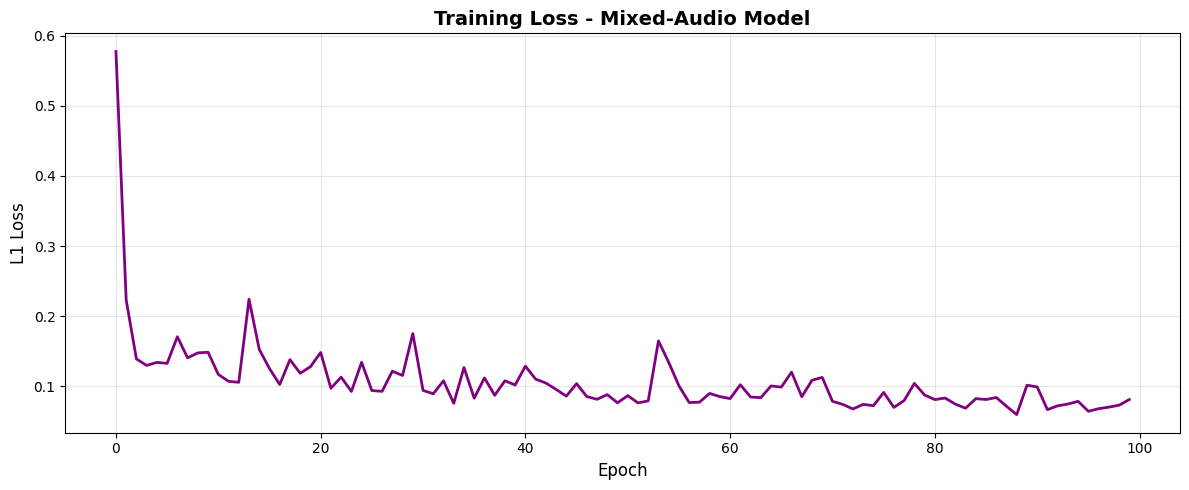


📈 Loss final: 0.080839
📉 Loss mínimo: 0.059379


In [12]:
plt.figure(figsize=(12, 5))
plt.plot(loss_history, 'purple', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('L1 Loss', fontsize=12)
plt.title('Training Loss - Mixed-Audio Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 Loss final: {loss_history[-1]:.6f}")
print(f"📉 Loss mínimo: {min(loss_history):.6f}")

## 💾 Step 9: Guardar Modelo

In [13]:
model_path = MODELS_DIR / "timeseries_srnet_audio_mixed.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Modelo guardado: {model_path}")

✅ Modelo guardado: ../models/timeseries_srnet_audio_mixed.pth


## 🔍 Step 10: Evaluación en Datos de Audio Test

In [14]:
# Cargar datos de test
x_test = np.loadtxt(training_dir / "x_audio_test.txt")
y_test = np.loadtxt(training_dir / "y_audio_test.txt")

def evaluate_model(model, x_test, y_test, device):
    model.eval()
    criterion = nn.L1Loss()
    
    with torch.no_grad():
        x_tensor = torch.tensor(x_test[:, np.newaxis, :], dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_test[:, np.newaxis, :], dtype=torch.float32).to(device)
        
        y_pred = model(x_tensor)
        loss = criterion(y_pred, y_tensor)
        
    return loss.item(), y_pred.cpu().numpy().squeeze()


test_loss, y_pred = evaluate_model(model, x_test, y_test, device)
print(f"📊 Test L1 Loss (Audio): {test_loss:.6f}")

📊 Test L1 Loss (Audio): 0.005023


## 📊 Step 11: Métricas

In [15]:
from scipy.stats import pearsonr

def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    correlations = [pearsonr(y_true[i], y_pred[i])[0] for i in range(len(y_true))]
    mean_corr = np.mean(correlations)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Mean Correlation': mean_corr}


metrics = calculate_metrics(y_test, y_pred)

print("="*60)
print("MÉTRICAS - MODELO MIXED-AUDIO")
print("="*60)
for metric, value in metrics.items():
    print(f"📊 {metric}: {value:.6f}")
print("="*60)

MÉTRICAS - MODELO MIXED-AUDIO
📊 MAE: 0.005023
📊 MSE: 0.000128
📊 RMSE: 0.011324
📊 Mean Correlation: 0.948130


## 📈 Step 12: Visualizar Predicciones

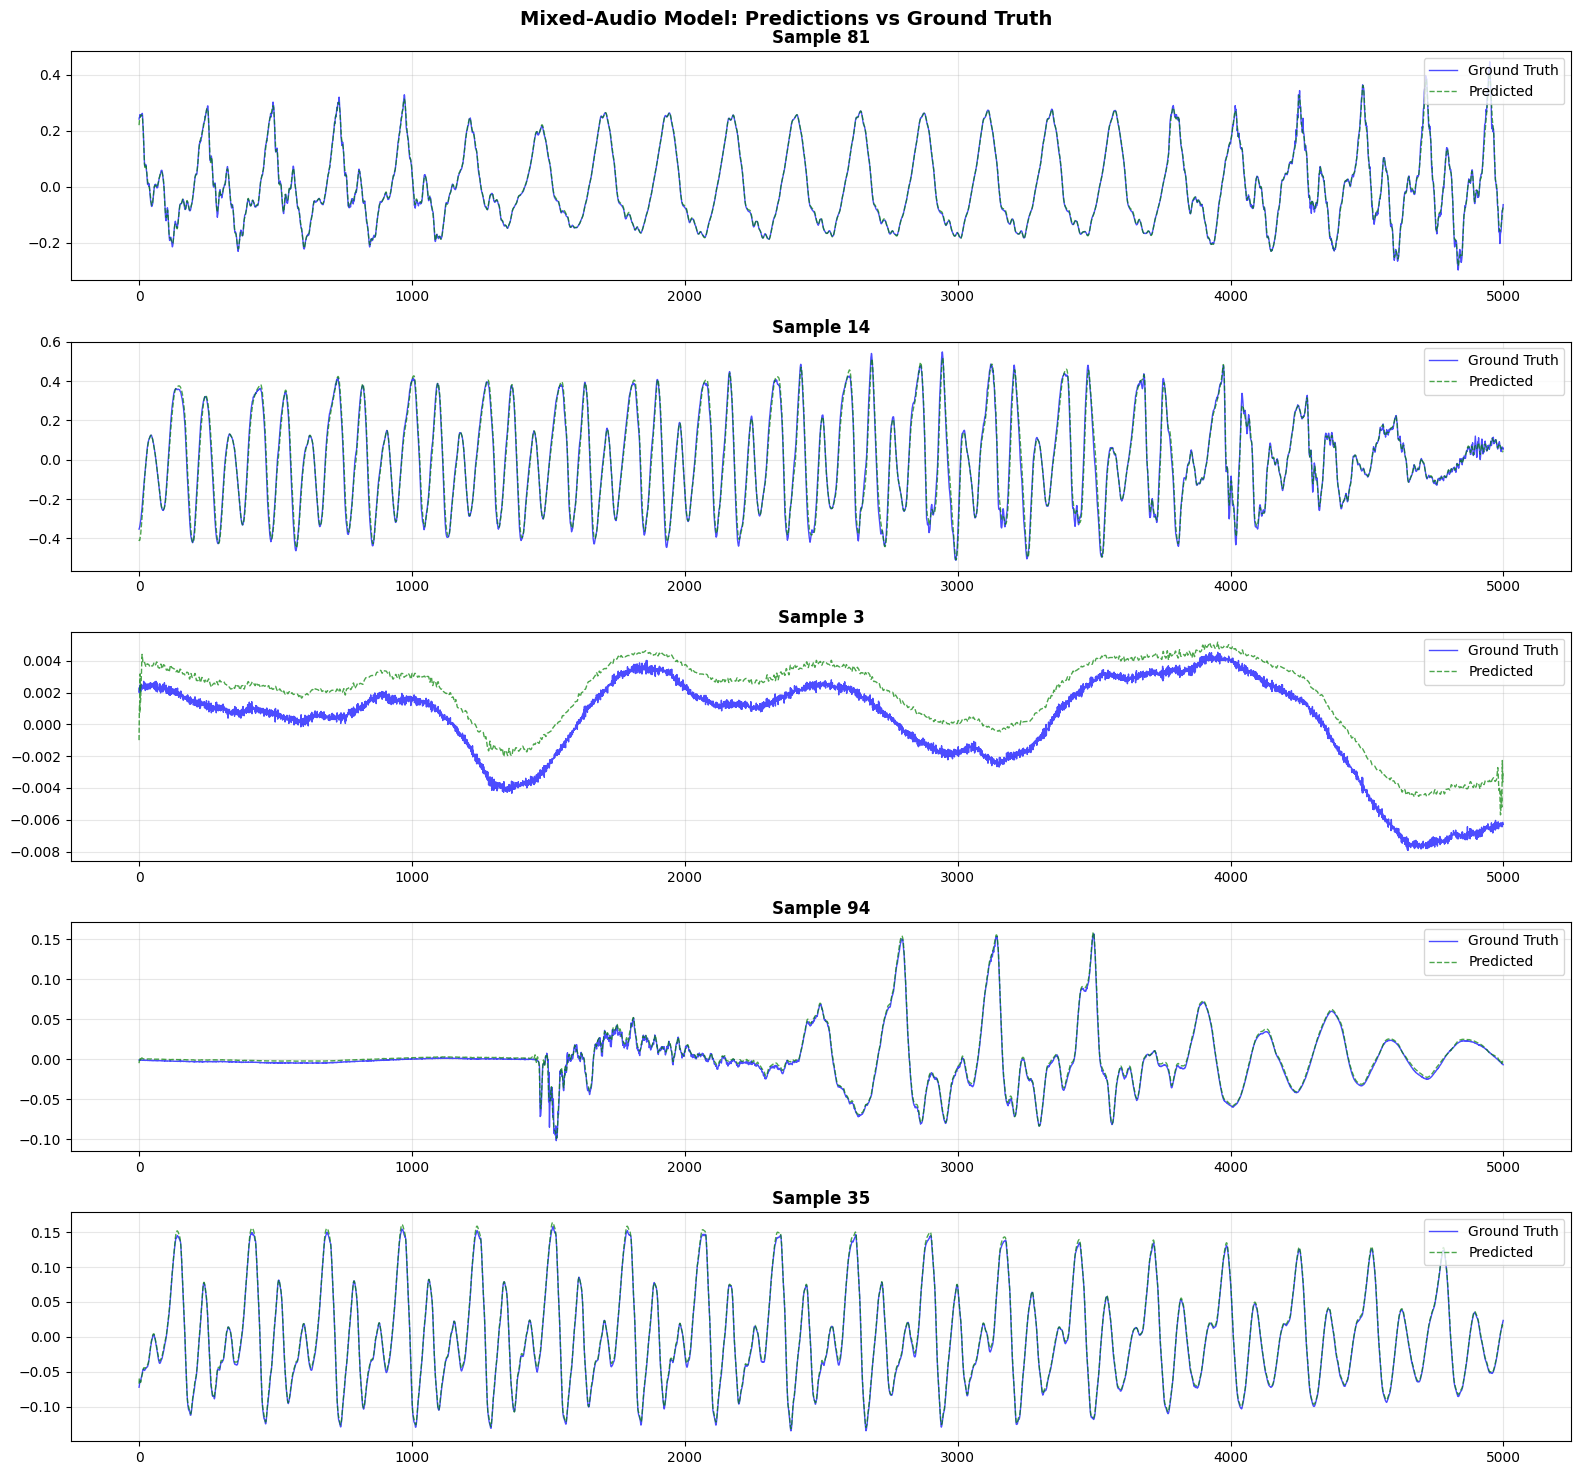

In [16]:
fig, axes = plt.subplots(5, 1, figsize=(16, 15))
indices = random.sample(range(len(y_test)), 5)

for i, idx in enumerate(indices):
    axes[i].plot(y_test[idx], 'b-', label='Ground Truth', linewidth=1, alpha=0.7)
    axes[i].plot(y_pred[idx], 'g--', label='Predicted', linewidth=1, alpha=0.7)
    axes[i].set_title(f'Sample {idx}', fontweight='bold')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Mixed-Audio Model: Predictions vs Ground Truth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()